<a href="https://colab.research.google.com/github/MehdiHachimi/Mathematics-for-New-Technologies-in-Finance-projects/blob/main/MNTF_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
# utility function
def utility(x):
  return tf.math.log(x)

In [58]:
# Markovian agent
class MarkovianAgent(tf.keras.Model):
    def __init__(self):
        super(MarkovianAgent, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(3,)),  # [time, wealth, price]
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='tanh')  # Output: π ∈ [-1, 1]
        ])

    def call(self, inputs):
        return self.model(inputs)

In [59]:
# Path-dependent agent
class PathDependentAgent(tf.keras.Model):
    def __init__(self):
        super(PathDependentAgent, self).__init__()
        self.lstm = tf.keras.layers.LSTM(32)
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='tanh')  # Output: π ∈ [-1, 1]
        ])

    def call(self, path_input):  # shape: [batch, time, 2] -> (wealth, price)
        x = self.lstm(path_input)
        return self.dense(x)

In [60]:
# Wealth simulation
def simulate_wealth(agent, price_paths, utility, initial_wealth=1000, path_dependent=False):
    batch_size, time_steps = price_paths.shape
    wealths = tf.ones((batch_size,)) * initial_wealth

    all_wealth_paths = []

    for t in range(time_steps - 1):
        S_t = price_paths[:, t]
        S_next = price_paths[:, t+1]
        ΔS = (S_next - S_t) / S_t


        if path_dependent:
            # build input: shape [batch, t+1, 2] = (W history, S history)
            W_hist = tf.stack(all_wealth_paths + [wealths], axis=1)
            S_hist = price_paths[:, :t+1]
            input_seq = tf.stack([W_hist, S_hist], axis=-1)
            π_t = agent(input_seq)
        else:
            time_input = tf.ones((batch_size, 1)) * t / time_steps
            input_vec = tf.concat([time_input, tf.expand_dims(wealths, -1), tf.expand_dims(S_t, -1)], axis=1)
            π_t = agent(input_vec)


        π_t = tf.squeeze(π_t)
        wealths = wealths * (1 + π_t * ΔS)
        all_wealth_paths.append(wealths)

    final_wealth = wealths
    utility_value = utility(final_wealth)
    return -tf.reduce_mean(utility_value)  # negative expected utility (loss)


In [61]:
def train(agent, model, utility_fn, path_dependent=False, epochs=50, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        if model == 'BS':
            price_paths = tf.convert_to_tensor(BS_paths(), dtype=tf.float32)
        if model == 'Heston':
            price_paths = tf.convert_to_tensor(Heston_paths(), dtype=tf.float32)
        if model == 'CEV':
            price_paths = tf.convert_to_tensor(CEV_paths(), dtype=tf.float32)
        with tf.GradientTape() as tape:
            loss = simulate_wealth(agent, price_paths, utility_fn, path_dependent=path_dependent)

        grads = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(grads, agent.trainable_variables))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss (neg expected utility): {loss.numpy():.4f}")


In [62]:
def test(agent, model, utility, path_dependent=False, initial_wealth=1000):
  if model == 'BS':
    price_paths = tf.convert_to_tensor(BS_paths(), dtype=tf.float32)
  if model == 'Heston':
    price_paths = tf.convert_to_tensor(Heston_paths(), dtype=tf.float32)
  if model == 'CEV':
    price_paths = tf.convert_to_tensor(CEV_paths(), dtype=tf.float32)

  batch_size, time_steps = price_paths.shape
  wealths = tf.ones((batch_size,)) * initial_wealth

  all_wealth_paths = []
  pi = []

  for t in range(time_steps - 1):
      S_t = price_paths[:, t]
      S_next = price_paths[:, t+1]
      ΔS = (S_next - S_t) / S_t


      if path_dependent:
          # build input: shape [batch, t+1, 2] = (W history, S history)
          W_hist = tf.stack(all_wealth_paths + [wealths], axis=1)
          S_hist = price_paths[:, :t+1]
          input_seq = tf.stack([W_hist, S_hist], axis=-1)
          π_t = agent(input_seq)

      else:
          time_input = tf.ones((batch_size, 1)) * t / time_steps
          input_vec = tf.concat([time_input, tf.expand_dims(wealths, -1), tf.expand_dims(S_t, -1)], axis=1)
          π_t = agent(input_vec)




      π_t = tf.squeeze(π_t)
      pi.append(π_t.numpy().tolist())
      wealths = wealths * (1 + π_t * ΔS)
      all_wealth_paths.append(wealths)

  return np.array(pi), np.array(all_wealth_paths)


#Black-Merton-Scholes#


In [63]:
# path generation
def BS_paths(S0=100, mu=0.1, T=1, sigma=0.2, M=100, I=10):
  """
  Parameters:
  S0 : Initial stock price
  mu : drift coeff
  T : end time
  sigma : Volatility
  M : Number of time steps for simulation
  I : Number of simulation paths
  """
  dt = T / M
  S = np.zeros((I, M+1))
  S[:,0] = S0
  for t in range(1, M + 1):
    z = np.random.standard_normal(I)
    S[:,t] = S[:,t-1] + mu * S[:,t-1] * dt + sigma * S[:,t-1] * np.sqrt(dt) * z
  return S


In [64]:
# first trading agent (Markovian)
markov_agent_BS = MarkovianAgent()
train(markov_agent_BS, 'BS', utility, path_dependent=False)

Epoch 0, Loss (neg expected utility): -6.7848
Epoch 10, Loss (neg expected utility): -6.8785
Epoch 20, Loss (neg expected utility): -6.7773
Epoch 30, Loss (neg expected utility): -6.8327
Epoch 40, Loss (neg expected utility): -6.8282


In [65]:
# test set
pi, wealth = test(markov_agent_BS, 'BS', utility, path_dependent=False)

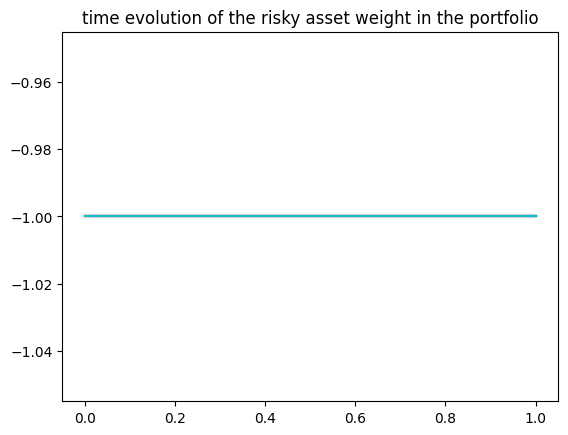

In [66]:
# results and plots
t = np.linspace(0, 1, pi.shape[0])
for i in range(pi.shape[1]):
  plt.plot(t, pi[:,i])
plt.title('time evolution of the risky asset weight in the portfolio')
plt.show()

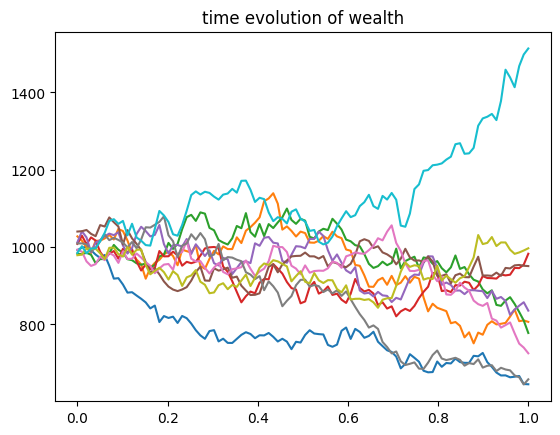

In [67]:
for i in range(wealth.shape[1]):
  plt.plot(t, wealth[:,i])
plt.title('time evolution of wealth')
plt.show()

In [68]:
# second trading agent (path-dependent)
path_dependent_agent_BS = PathDependentAgent()
train(path_dependent_agent_BS, 'BS', utility, path_dependent=True)

Epoch 0, Loss (neg expected utility): -6.8884
Epoch 10, Loss (neg expected utility): -6.9249
Epoch 20, Loss (neg expected utility): -6.9714
Epoch 30, Loss (neg expected utility): -6.9109
Epoch 40, Loss (neg expected utility): -6.9742


In [69]:
# test set
pi, wealth = test(path_dependent_agent_BS, 'BS', utility, path_dependent=True)

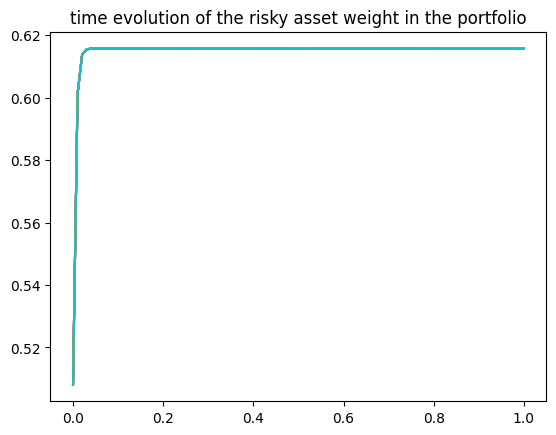

In [70]:
# results and plots
t = np.linspace(0, 1, pi.shape[0])
for i in range(pi.shape[1]):
  plt.plot(t, pi[:,i])
plt.title('time evolution of the risky asset weight in the portfolio')
plt.show()

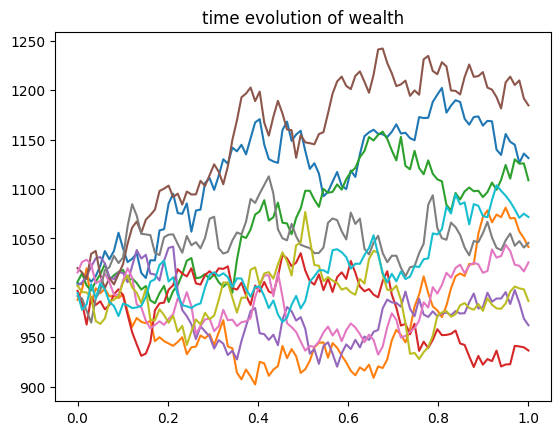

In [71]:
for i in range(wealth.shape[1]):
  plt.plot(t, wealth[:,i])
plt.title('time evolution of wealth')
plt.show()

#Heston#

In [72]:
# path generation
def Heston_paths(S0=100, T=1, mu=0.02, kappa=4.0, theta=0.02, v_0=0.02, rho=0.7, xi=0.9, M=100, I=10):
  """
  Parameters:
  S0 : Initial stock price
  mu : drift coeff
  kappa : speed of mean reversion
  theta : long-term mean volatility level
  v_0 : instantaneous volatility (variance) at time 0
  rho : correlation of the two Brownian motions
  xi : volatility of volatility
  T : end time
  M : Number of time steps for simulation
  I : Number of simulation paths
  """
  dt = T/M
  S = np.zeros((I,M+1))
  v = np.zeros((I,M+1))
  S[:,0] = S0
  v[:,0] = v_0
  for t in range(1, M+1):
    dW = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),size=I) * np.sqrt(dt)
    S[:,t] = S[:,t-1] + mu * S[:,t-1] * dt + np.sqrt(v[:,t-1]) * S[:,t-1] * dW[:, 0]
    # Enforce that variance remains bigger or equal than 0
    v[:,t] = np.maximum(v[:,t-1] + kappa * (theta - np.maximum(v[:,t-1], 0)) * dt + xi * np.sqrt(np.maximum(v[:,t-1], 0)) * dW[:, 1], 0)
  return S


In [73]:
# first trading agent (Markovian)
markov_agent_Heston = MarkovianAgent()
train(markov_agent_Heston, 'Heston', utility, path_dependent=False)

Epoch 0, Loss (neg expected utility): -6.8892
Epoch 10, Loss (neg expected utility): -6.9029
Epoch 20, Loss (neg expected utility): -6.9362
Epoch 30, Loss (neg expected utility): -6.9144
Epoch 40, Loss (neg expected utility): -6.9051


In [74]:
# test set
pi, wealth = test(markov_agent_Heston, 'Heston', utility, path_dependent=False)

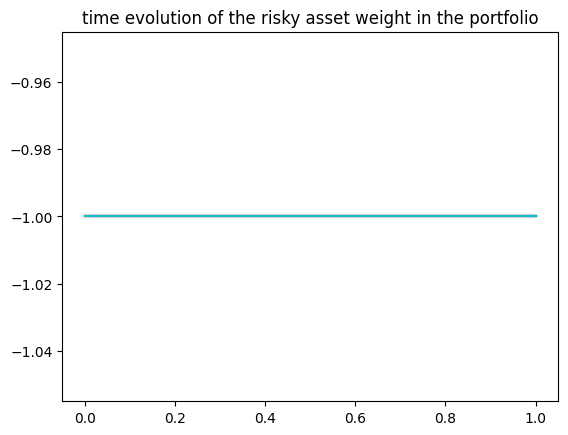

In [75]:
# results and plots
t = np.linspace(0, 1, pi.shape[0])
for i in range(pi.shape[1]):
  plt.plot(t, pi[:,i])
plt.title('time evolution of the risky asset weight in the portfolio')
plt.show()

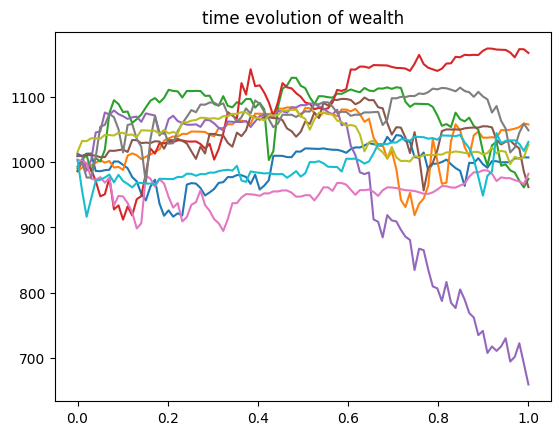

In [76]:
for i in range(wealth.shape[1]):
  plt.plot(t, wealth[:,i])
plt.title('time evolution of wealth')
plt.show()

In [77]:
# second trading agent (path-dependent)
path_dependent_agent_Heston = PathDependentAgent()
train(path_dependent_agent_Heston, 'Heston', utility, path_dependent=True)

Epoch 0, Loss (neg expected utility): -6.9091
Epoch 10, Loss (neg expected utility): -6.9117
Epoch 20, Loss (neg expected utility): -6.9048
Epoch 30, Loss (neg expected utility): -6.9122
Epoch 40, Loss (neg expected utility): -6.9072


In [78]:
# test set
pi, wealth = test(path_dependent_agent_Heston, 'Heston', utility, path_dependent=True)

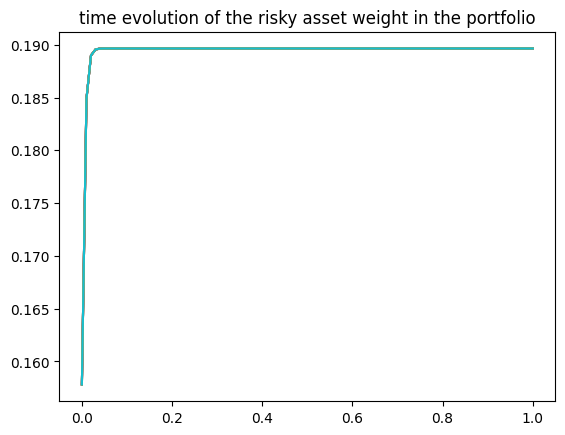

In [79]:
# results and plots
t = np.linspace(0, 1, pi.shape[0])
for i in range(pi.shape[1]):
  plt.plot(t, pi[:,i])
plt.title('time evolution of the risky asset weight in the portfolio')
plt.show()

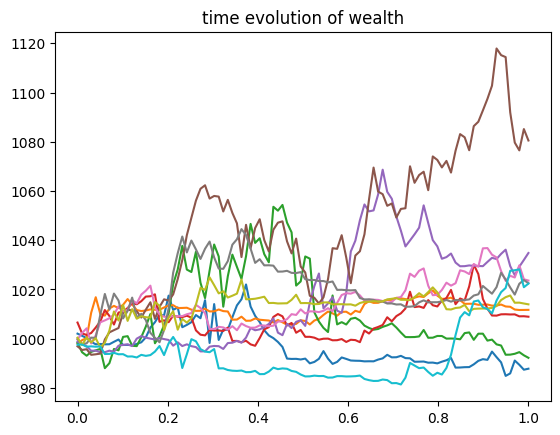

In [80]:
for i in range(wealth.shape[1]):
  plt.plot(t, wealth[:,i])
plt.title('time evolution of wealth')
plt.show()

#CEV#

In [81]:
def CEV_paths(S0=100, mu=0.1, sigma=0.2, gamma=0.5, T=1, M=100, I=10):
  """
  Parameters:
  S0 : Initial stock price
  mu : drift coeff
  T : end time
  sigma : Volatility
  gamma : factor that controls the relationship between volatility and price
  M : Number of time steps for simulation
  I : Number of simulation paths
  """
  dt = T / M
  S = np.zeros((I, M+1))
  S[:,0] = S0
  for t in range(1, M + 1):
    z = np.random.standard_normal(I)
    S[:,t] = S[:,t-1] + mu * S[:,t-1] * dt + sigma * S[:,t-1]**gamma * np.sqrt(dt) * z
  return S


In [82]:
# first trading agent (Markovian)
markov_agent_CEV = MarkovianAgent()
train(markov_agent_CEV, 'CEV', utility, path_dependent=False)

Epoch 0, Loss (neg expected utility): -7.0181
Epoch 10, Loss (neg expected utility): -7.0031
Epoch 20, Loss (neg expected utility): -7.0135
Epoch 30, Loss (neg expected utility): -7.0085
Epoch 40, Loss (neg expected utility): -7.0076


In [83]:
# test set
pi, wealth = test(markov_agent_CEV, 'CEV', utility, path_dependent=False)

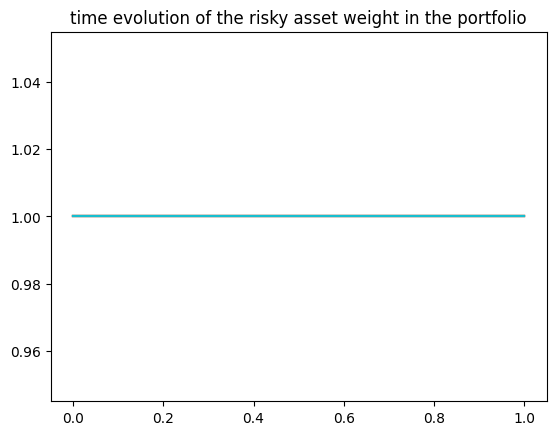

In [84]:
# results and plots
t = np.linspace(0, 1, pi.shape[0])
for i in range(pi.shape[1]):
  plt.plot(t, pi[:,i])
plt.title('time evolution of the risky asset weight in the portfolio')
plt.show()

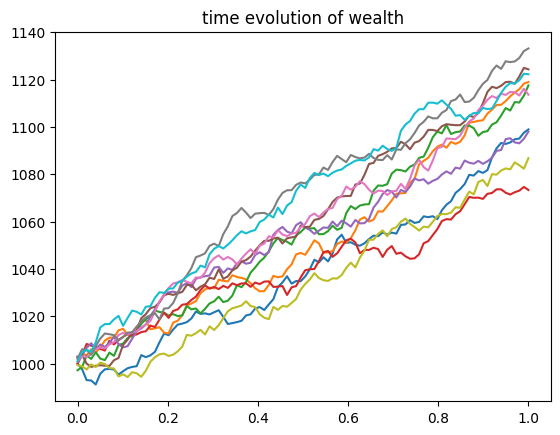

In [85]:
for i in range(wealth.shape[1]):
  plt.plot(t, wealth[:,i])
plt.title('time evolution of wealth')
plt.show()

In [86]:
# second trading agent (path-dependent)
path_dependent_agent_CEV = PathDependentAgent()
train(path_dependent_agent_CEV, 'CEV', utility, path_dependent=True)

Epoch 0, Loss (neg expected utility): -6.9540
Epoch 10, Loss (neg expected utility): -6.9742
Epoch 20, Loss (neg expected utility): -6.9880
Epoch 30, Loss (neg expected utility): -6.9924
Epoch 40, Loss (neg expected utility): -6.9994


In [87]:
# test set
pi, wealth = test(path_dependent_agent_CEV, 'CEV', utility, path_dependent=True)

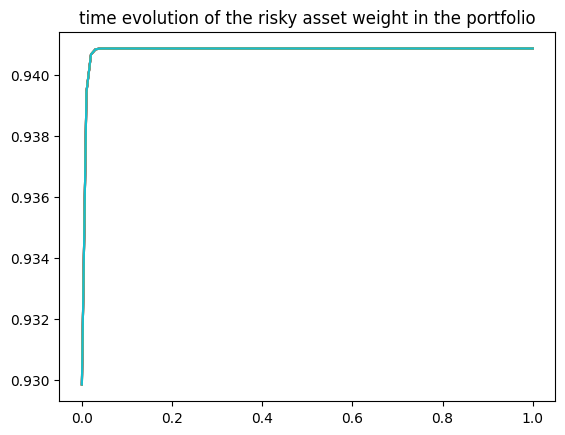

In [88]:
# results and plots
t = np.linspace(0, 1, pi.shape[0])
for i in range(pi.shape[1]):
  plt.plot(t, pi[:,i])
plt.title('time evolution of the risky asset weight in the portfolio')
plt.show()

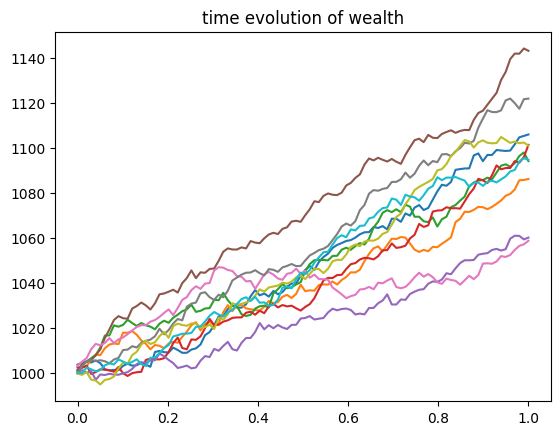

In [89]:
for i in range(wealth.shape[1]):
  plt.plot(t, wealth[:,i])
plt.title('time evolution of wealth')
plt.show()

##Discussion##

For the 3 models, we observe that the Markovian agent is either fully invested in the risky asset or fully betting against it. While for the path-dependent agent, we observe that the trading agent quickly stabilizes its position to  a constant proportion of the portfolio invested in the risky asset (this makes sense for the BS model as we saw in class that the optimal proportion is constant, but I am not sure how to interpret it for the other two models since we do not have closed form results).

Regarding the final wealth value, we observe that in the BS and Heston models, the path-dependent agent performs better than the Markovian agent. For the CEV model, both of them perform well.

Some potential improvements would be to perform regularization to avoid overfitting, trying other architectures, performing feature engineering, increasing the number of epochs or performing a cross validation to get the optimal number of epochs to use, refining the time grid, and finally increasing the number of simulation paths.

I tried some of these improvements but either my computer crashed or it was taking too long to run...